# **1.** **Frame the Problem and Look at the Big Picture**

**Project Goal:**
* Model’s output (a prediction of a district’s `median housing price`) will determine whether it is worth investing in a given area. Getting this right is critical, as it directly affects revenue.

**Designing the System:**
* `Supervised Learning` because model can be trained with labeled examples
* Typical `Regression` task since the model will be asked to predicted a value
  * More specifically, this is a `multiple regression` problem, since the system will use multiple features to make prediction and 
  * It is also `Univariate regression` problem, since we are only trying to predict a single value for each district.
* There is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain ***batch learning*** should do just fine.

**Select a Performance Measure:**
* RMSE (Root Mean Square Error)
* MAE (Mean Absolute Error)<br>
  We will use both<br><br>
**NOTES:**
* The RMSE is more sensitive to outliers than the MAE.
* If Outliers are rare RMSE performs very well

**Libraries to Use In Project:**

In [125]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import os
import sys

import warnings
warnings.filterwarnings("ignore")

In [126]:
### Add Project Path
# Get the current working directory
current_dir = os.getcwd()

# Find the project root directory
project_root = current_dir  # Start with the current directory initially
while not os.path.exists(os.path.join(project_root, 'house-price-prediction')):
    # Go up one directory until finding the 'house-price-prediction' folder
    project_root = os.path.dirname(project_root)

# Append the project path to the system path
sys.path.append(os.path.join(project_root, "house-price-prediction"))

In [127]:
# My Scripts
from utility.data_visualization_utils import save_fig

# **2.** **Get the Data**

## **2.1.** **Download and Load the Dataset**

In [128]:
# Load the Dataset
df = pd.read_csv('../data/housing.csv')

## **2.2.** **Take a Quick Look at the Data Structure**

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [130]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Observations:**
* We have 20640 entries and 10 features
* we can quickly identify columns with missing data: Only `total_bedrooms` have null values.
* All attributes are numerical, except for `ocean_proximity`

**Feature Summary:**

*Features:*

1. `longitude`: A measure of how far west a house is; a higher value is farther west
2. `latitude`: A measure of how far north a house is; a higher value is farther north
3. `housing_median_age`: Median age of a house within a block; a lower number is a newer building
4. `total_rooms`: Total number of rooms within a block
5. `total_bedrooms`: Total number of bedrooms within a block
6. `population`: Total number of people residing within a block
7. `households`: Total number of households, a group of people residing within a home unit, for a block
8. `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9.  `ocean_proximity`: Location of the house w.r.t ocean/sea
    
*Target Variable:*

1. `median_house_value`: Median house value for households within a block (measured in US Dollars)

When we look at the top five rows, noticed that `ocean_proximity` repetitive, which means that it is probably categorical attribute.<br>
Let's look at what categories exist and how many districts belong to each category:

In [131]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Let's look at the other fields; **summary of the numerical attributes:**

In [132]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


**We can find possible skewness from statistics:**
* `total_rooms`: mean 2635.76, median 1447.75 --- *right (positive) skewness.*
* `total_bedrooms`: mean 537.87, median 435 --- *right (positive) skewness.*
* `population`: mean 1425.47, median 1166 --- *right (positive) skewness.*
* `households`: mean 499.53, median 409 --- *right (positive) skewness.*
* `median_income`: mean 3.87, median 3.53 --- *right (positive) skewness.*

Let's look at the histogram for each numerical attribute for understanding data we're dealing with

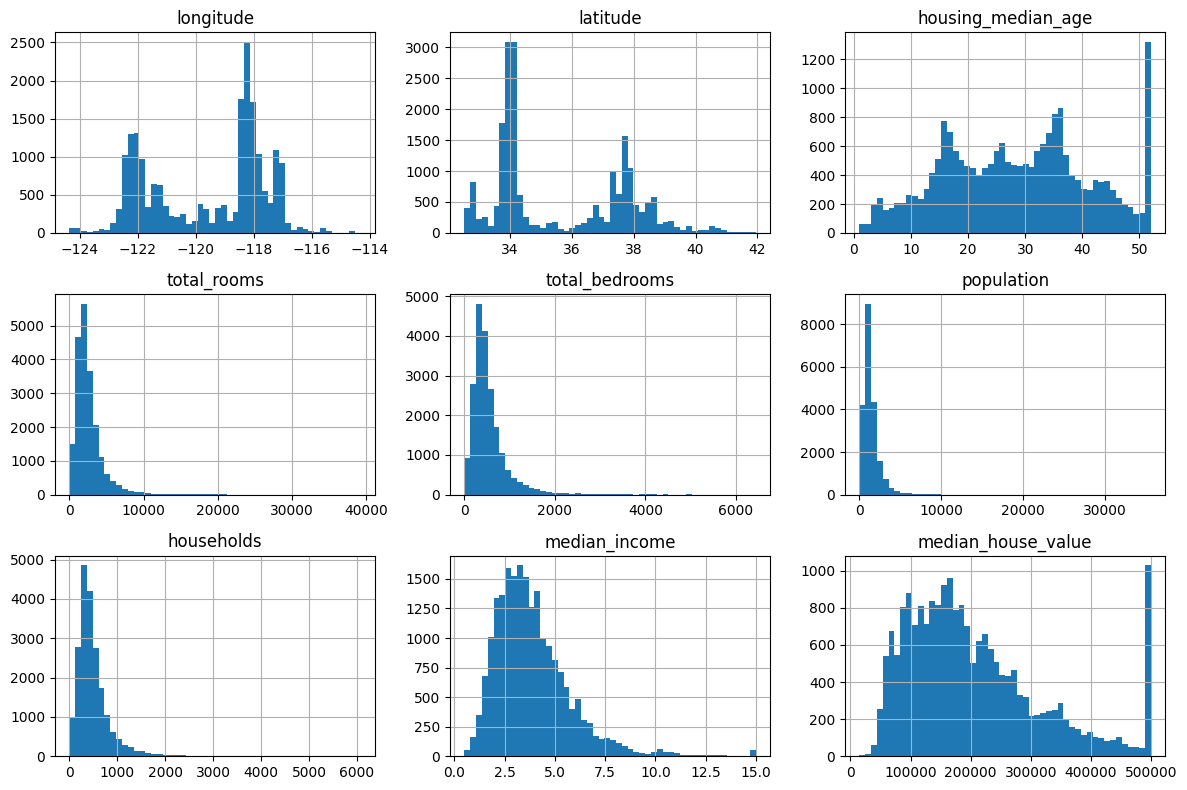

In [133]:
df.hist(bins=50, figsize=(12, 8))
save_fig("all_num_features_hist")
plt.show()

**Observation from Histograms:**

1. `median income` attribute:
   * Has been scaled and capped at ***15 (15.0001)*** for higher incomes, and at ***0.5 (0.4999)*** for lower median incomes
   * The numbers represent roughly tens of thousands of dollars *(eg. 3 is $30,000)*
2. `housing median age` attribute:
   * capped at 52.0 for higher house ages
3. `median house value` attribute *(Target Variable)*:  
   * Capped at 500001.00 for higher, this maybe a problem because model may learn that prices never go beyond that limit, If we want to predict house prises beyond, we have to options:
     1. Collect proper labels
     2. Remove those districts from the training and test set
4. Attributes have very different scales. We need to correct this.
5. Many histograms are **skewed right**, this may make it harder some ML algorithms to detect patterns. We need try transform these attributes to have more symmetrical and bell-shaped distributions.

## **2.3.** **Create Test Set:**

*1. Automatic Partition with Scikit-learn Library:*

In [134]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

*2. Stratified Sampling:*

1. Find more imported feature for predicting target value `median_house_value`

In [135]:
df.select_dtypes(include=['number']).corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Most imported attribute is `median_income` with 0.688075. We want to ensure that the test set representative of various categories of income.

Since the median income is a continuous numerical attribute, first we need to create an income category attribute. Let's look at the histogram of `median_income`

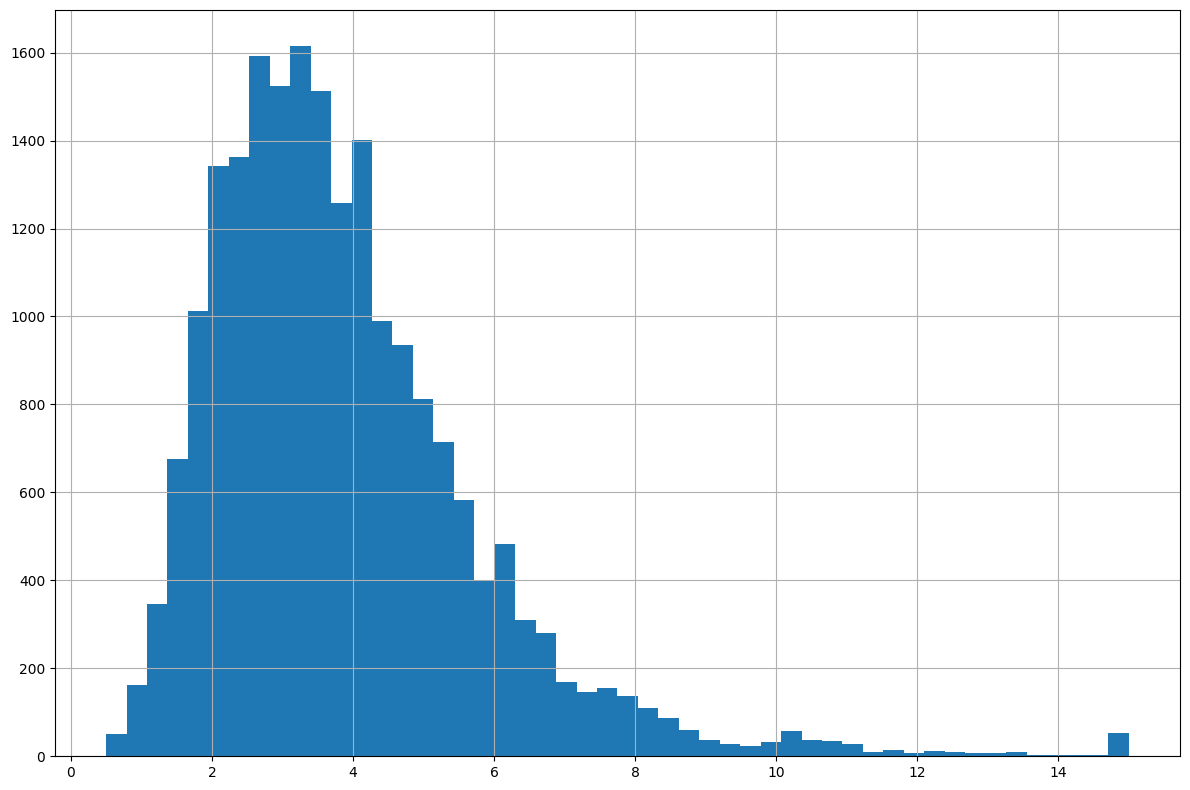

In [136]:
df['median_income'].hist(bins=50, figsize=(12, 8))
save_fig("median_income_fig")
plt.show()

Most median income values clustered around 1.5 to 6, but some median incomes go far beyond 6. To avoid sampling bias we need to have sufficient number of instances of a stratum in dataset for each stratum.<br>
**NOTE:** We should not have too many strata, and each stratum should be large enough.

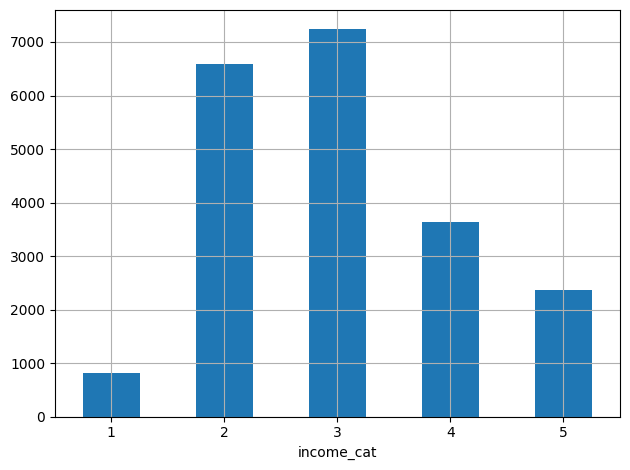

In [137]:
df['income_cat'] = pd.cut(df['median_income'],
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])

df['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
save_fig("income_cat")

In [138]:
strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, stratify=df['income_cat'],random_state=42)

Let's compare proportion of random split and stratified split

In [139]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(df),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),    
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.02,0.36,0.97
2,31.88,31.88,32.44,-0.02,1.73
3,35.06,35.05,35.85,-0.01,2.27
4,17.63,17.64,16.74,0.03,-5.06
5,11.44,11.43,10.95,-0.08,-4.32


The test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed.

We will use **Stratified Split** in the project

We don't need to use the income_cat column again; we might drop it, and revert the data back to its original state:

In [140]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# **3.** **Explore the Data**

In [141]:
# Copy the training Set
housing = strat_train_set.copy()

## **3.1.** **Visualizing Geographical Data**

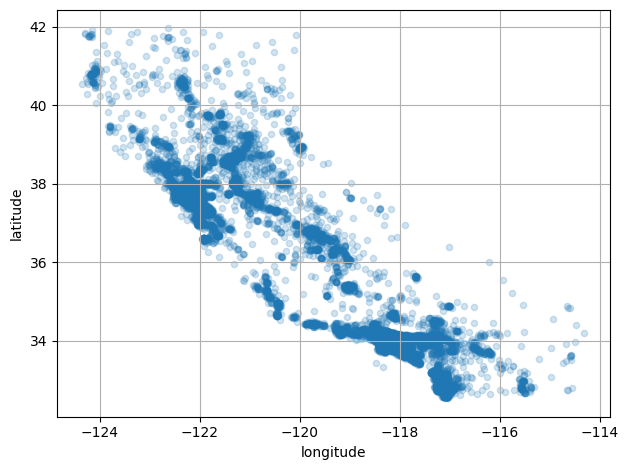

In [142]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, 
             alpha=0.2)
save_fig("geo_high-density_areas")
plt.show()

We can clearly see the high-density areas, namely the *Bay Area* and around *Los Angeles* and *San Diego*, plus a long line of fairly high-density areas in the *Central Valley* (in particular, around Sacramento and Fresno).

Let's look at te housing prices:
* `s`: The radius of each circle represents the district's **population**
* `c`: The color represents the **price**

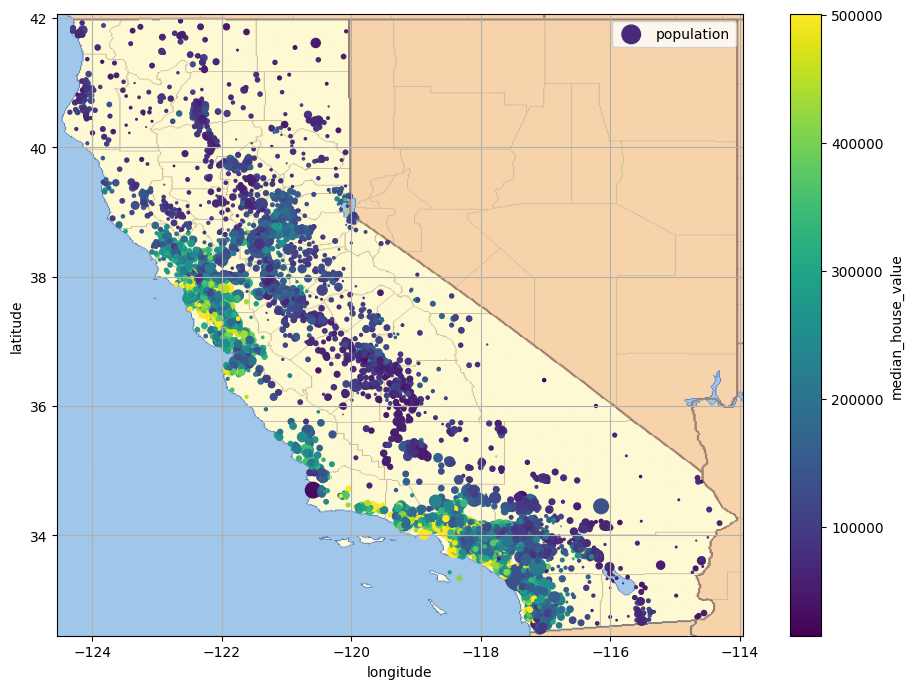

In [143]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing['population'] / 100, label="population",
             c="median_house_value", cmap="viridis", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread('../images/california.png')
axis = -124.55, -113.95, 32.45, 42.05
plt.imshow(california_img, extent=axis)

save_fig('california_housing_prices')
plt.show()

## **3.2.** **Look for Correlations**

In [144]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()

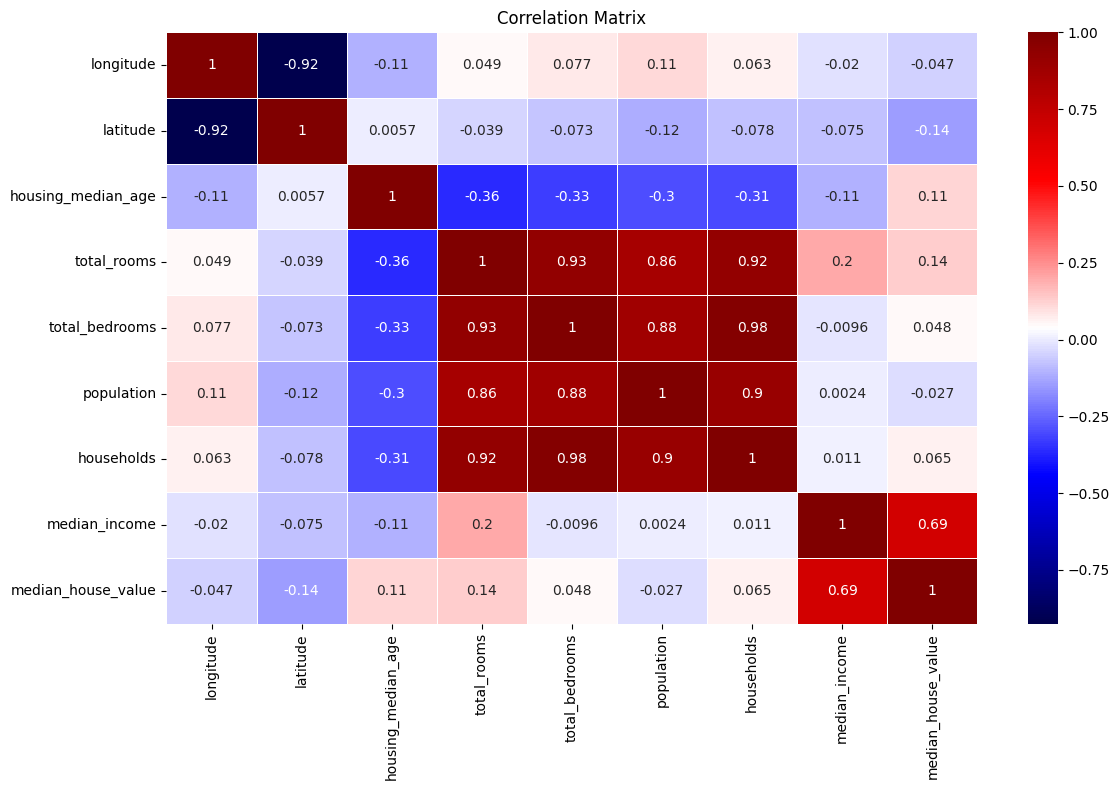

In [145]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', linewidths=.5)
plt.title('Correlation Matrix')

save_fig("correlation_matrix")
plt.show()

In [146]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

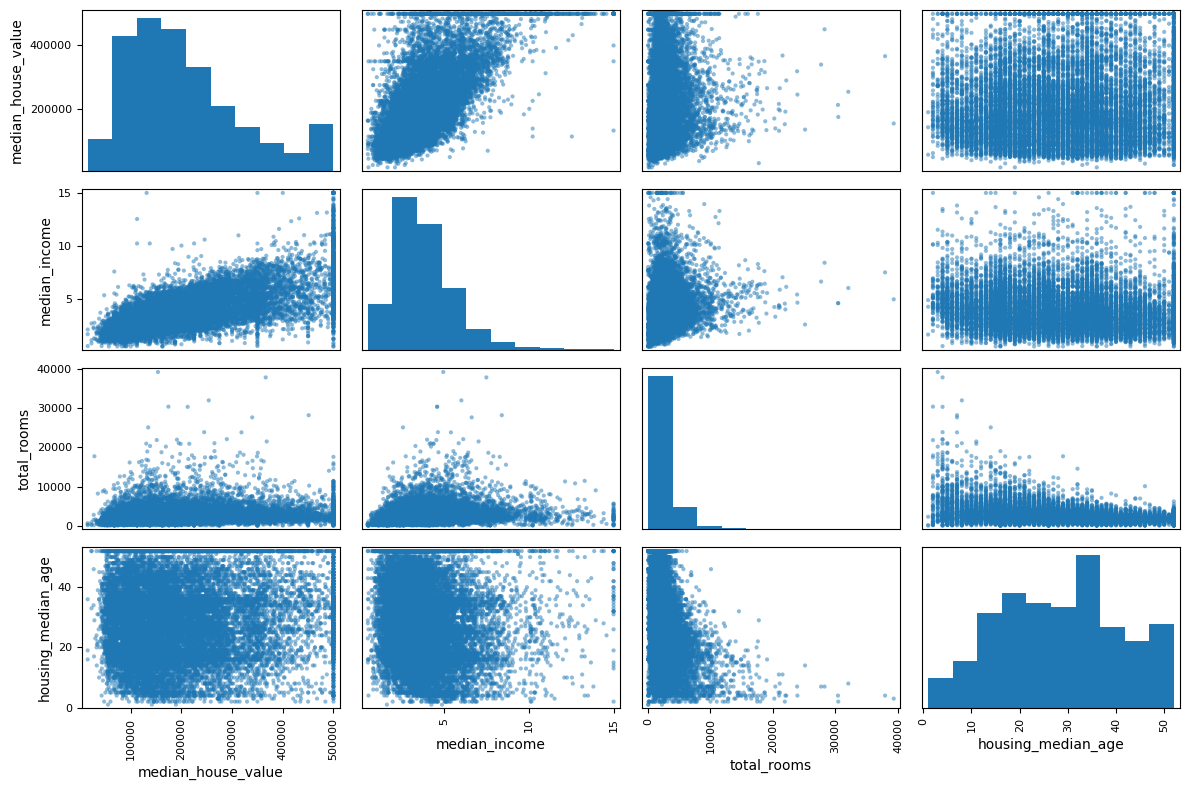

In [147]:
attributes = ["median_house_value",
              "median_income",
              "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

save_fig("scatter_matrix_most_sign_features")
plt.show()

We saw correlation matrix, now let's produce useful features

## **3.3.** **Feature Engineering**

In [148]:
housing["room_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [149]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
room_per_house        0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ratio       -0.259952
Name: median_house_value, dtype: float64

**Training Set after Feature Extraction:**

In [150]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,room_per_house,bedrooms_ratio,people_per_house
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,0.182692,3.167241


# **4.** **Prepare the Data**

First we want to revert to a clean training set (by copying strat_train_set once again). We don’t necessarily want to apply the same transformations to the predictors and the target values for that we should separate the predictors and the labels

In [151]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

For preparing the train data, we would like the split predictors to `numerical` and `categorical`

In [152]:
def separate_numerical_categorical(data):
    """
    Separates numerical and categorical columns in a DataFrame.

    Args:
    - data (DataFrame): Input DataFrame containing mixed column types.

    Returns:
    - num_data (DataFrame): DataFrame containing only numerical columns.
    - cat_data (DataFrame): DataFrame containing only categorical columns.
    """
    num_data = data.select_dtypes(include=[np.number])
    cat_data = data.select_dtypes(include=["object"])
    return num_data, cat_data

## **4.1.** **Clean the Data**

In [153]:
# Find rows containing null values
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


I would like to create for filling data with `SimpleImputer`<br>
Function will be:
1. Split Data **numeric** and **other**
2. Impute the data with necessary strategies
   * "median" for numeric
   * "most_frequent" for categoric
3. Combine these and return with imputed DataFrame

In [154]:
def impute_missing_values(data, num_strategy="median", cat_strategy="most_frequent"):
    """
    A function that uses SimpleImputer to fill missing values in numerical and categorical columns.

    Args:
    - num_df (DataFrame): The numerical features from dataset with missing values to be filled.
    - data (DataFrame): The categorical feature from dataset with missing values to be filled.
    - num_strategy (str, optional): Strategy for filling numerical columns (default: 'median').
    - cat_strategy (str, optional): Strategy for filling categorical columns (default: 'most_frequent').

    Returns:
    - filled_data (DataFrame): Dataset with missing values filled.
    """
    # Separating numerical and categorical columns
    num_data, cat_data = separate_numerical_categorical(data)

    # Filling numerical columns
    num_imputer = SimpleImputer(strategy=num_strategy)
    num_imputer.fit(num_data)
    num_data_filled = num_imputer.transform(num_data)
    num_data_filled = pd.DataFrame(num_data_filled,
                                   columns=num_data.columns,
                                   index=num_data.index)

    # Filling categorical columns
    cat_imputer = SimpleImputer(strategy=cat_strategy)
    cat_imputer.fit(cat_data)
    cat_data_filled = cat_imputer.transform(cat_data)
    cat_data_filled = pd.DataFrame(cat_data_filled,
                                      columns=cat_data.columns,
                                      index=cat_data.index)

    # Combining filled numerical and categorical columns
    filled_data = pd.concat([num_data_filled, cat_data_filled], axis=1)

    return filled_data


housing = impute_missing_values(housing)

In [155]:
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [156]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


## **4.2.** **Drop Some Outliers**

Before removing outliers first we want to separate data again:

In [157]:
housing_num, _ = separate_numerical_categorical(housing)

Let's find outliers with `IsolationForest` from numerical attributes

In [158]:
isolation_forest = IsolationForest(random_state=42)
# Fitting the Isolation Forest model and predicting outliers
outlier_pred = isolation_forest.fit_predict(housing_num)

outlier_pred

array([ 1, -1,  1, ...,  1,  1,  1])

In [159]:
# Drop Outliers
housing = housing.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

## **4.3.** **Handling Text and Categorical Attributes**

We have only one text Attribute: `ocean_proximity`

In [160]:
housing_num, housing_cat = separate_numerical_categorical(housing)

In [161]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          6553
INLAND             4433
NEAR OCEAN         1805
NEAR BAY           1603
ISLAND                2
Name: count, dtype: int64

It's not arbitrary text: there are a limited number of possible values, each of which represents a category. So this attribute is a categorical attribute

We will use `OneHotEncoder` for encoding this attribute

In [162]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<14396x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14396 stored elements in Compressed Sparse Row format>

In [163]:
housing_cat_1hot_df = pd.DataFrame(housing_cat_1hot.toarray(), 
                                   columns=cat_encoder.get_feature_names_out(housing_cat.columns))
housing_cat_1hot_df

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
14391,1.0,0.0,0.0,0.0,0.0
14392,1.0,0.0,0.0,0.0,0.0
14393,1.0,0.0,0.0,0.0,0.0
14394,1.0,0.0,0.0,0.0,0.0


## **4.4.** **Feature Transformation**

We did found that some of the features has positively skewed. These features are:
* `total_bedrooms`
* `total_rooms`
* `population`
* `households`
* `median_income`<br>
Some of these has a really long heavy tail, such as ***power law distribution,*** 
* Replacing the feature with its **logarithm** may help OR 
* Replacing the feature with its **square root** may help

Let's see both of these options with these features

In [164]:
def plot_log(data, column, bins=50):
    """
    Plots the histogram of a column and its logarithm.

    Args:
    - data (DataFrame): Input DataFrame containing the column to be visualized.
    - column (str): Column name to be visualized.
    - figsize (tuple, optional): Figure size (default: (8, 3)).
    - bins (int, optional): Number of bins for the histograms (default: 50).
    """
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    data[column].hist(ax=axs[0], bins=bins)
    data[column].apply(np.log).hist(ax=axs[1], bins=bins)
    axs[0].set_xlabel(column)
    axs[1].set_xlabel(f"Log of {column}")
    axs[0].set_ylabel("Number of districts")
    plt.show()

In [165]:
def plot_sqrt(data, column, bins=50):
    """
    Plots the histogram of a column and its square root.

    Args:
    - data (DataFrame): Input DataFrame containing the column to be visualized.
    - column (str): Column name to be visualized.
    - bins (int, optional): Number of bins for the histograms (default: 50).
    """
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    data[column].hist(ax=axs[0], bins=bins)
    data[column].apply(np.sqrt).hist(ax=axs[1], bins=bins)
    axs[0].set_xlabel(column)
    axs[1].set_xlabel(f"Sqrt of {column}")
    axs[0].set_ylabel("Number of districts")
    plt.show()

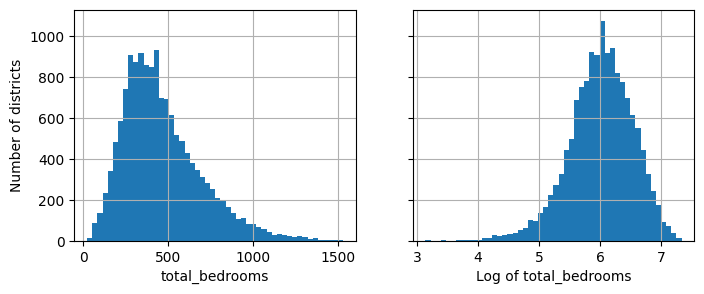

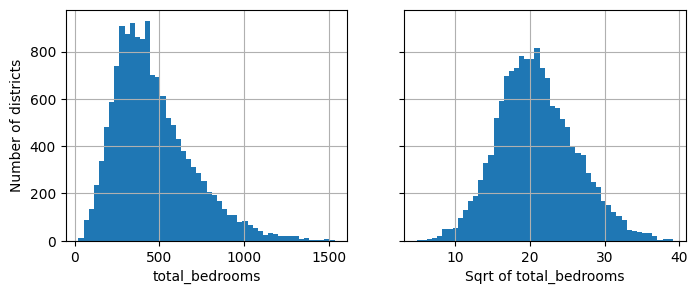

In [166]:
plot_log(housing, "total_bedrooms")
plot_sqrt(housing, "total_bedrooms")

For `total_bedrooms` feature **square root** option looks better

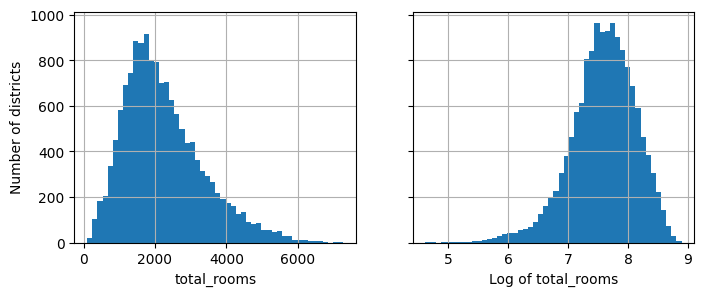

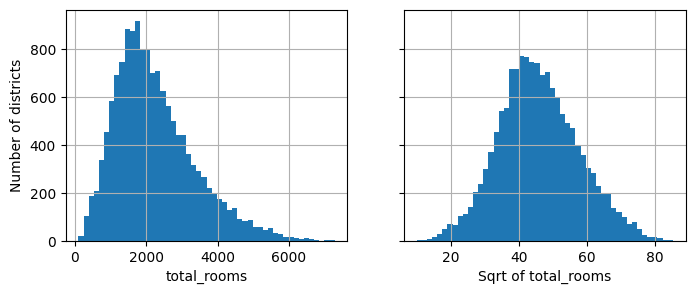

In [167]:
plot_log(housing, "total_rooms")
plot_sqrt(housing, "total_rooms")

For `total_rooms` feature **square root** option looks better

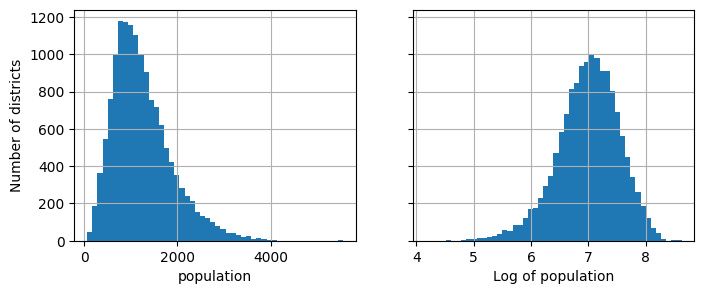

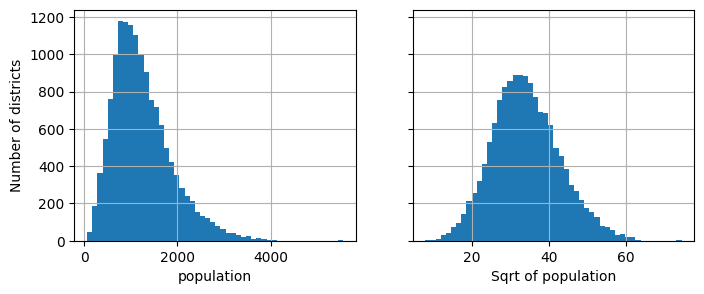

In [168]:
plot_log(housing, "population")
plot_sqrt(housing, "population")

For `population` feature **log** option looks better

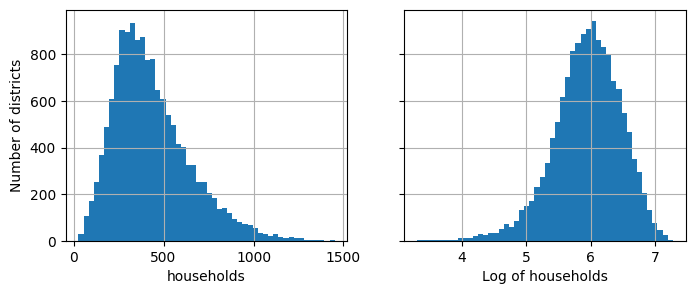

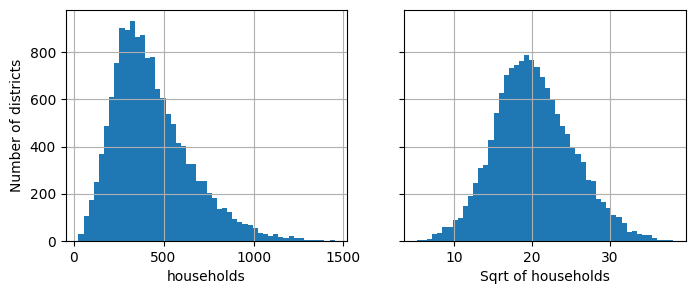

In [169]:
plot_log(housing, "households")
plot_sqrt(housing, "households")

For `households` feature **square root** option looks better

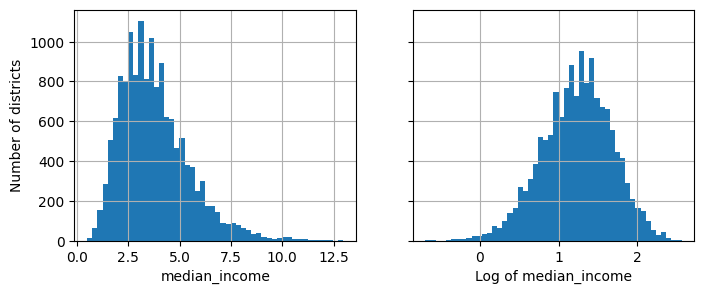

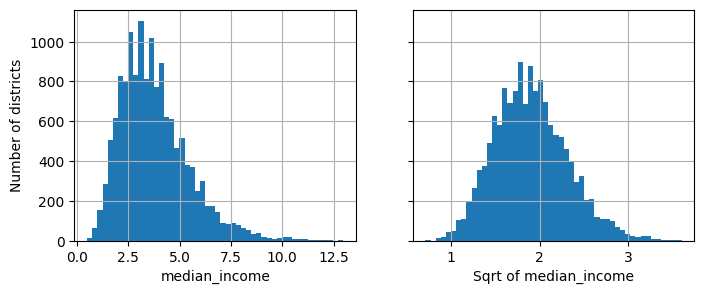

In [170]:
plot_log(housing, "median_income")
plot_sqrt(housing, "median_income")

For `median_income` feature **log** option looks better

Feature to be log-transformed:
1. `population`
2. `median_income`

Feature to be square root:
1. `total_bedrooms`
2. `total_rooms`
3. `households`

Let's create functions that does these transformations:

In [171]:
def sqrt_transform(data, columns):
    """
    Apply square root transformation to specified columns in a DataFrame.

    Args:
    - data (DataFrame): Input DataFrame containing columns to be transformed.
    - columns (list): List of column names to apply square root transformation.
    """
    data[columns] = data[columns].apply(np.sqrt)

def log_transform(data, columns):
    """
    Apply logarithm transformation to specified columns in a DataFrame.

    Args:
    - data (DataFrame): Input DataFrame containing columns to be transformed.
    - columns (list): List of column names to apply logarithm transformation.
    """
    data[columns] = data[columns].apply(np.log)

In [172]:
sqrt_transform(housing, ["total_bedrooms", "total_rooms", "households"])
log_transform(housing, ["population", "median_income"])

In [173]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14396 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14396 non-null  float64
 1   latitude            14396 non-null  float64
 2   housing_median_age  14396 non-null  float64
 3   total_rooms         14396 non-null  float64
 4   total_bedrooms      14396 non-null  float64
 5   population          14396 non-null  float64
 6   households          14396 non-null  float64
 7   median_income       14396 non-null  float64
 8   ocean_proximity     14396 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.1+ MB


## **4.4.** **Feature Extraction**

Let's find 10 cluster centers

In [174]:
# Clustering with KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit_transform(housing[["latitude", "longitude"]],
                     sample_weight=housing_labels)

# Calculate similarities using cluster centers
cluster_centers = kmeans.cluster_centers_
similarities = rbf_kernel(housing[["latitude", "longitude"]], cluster_centers, gamma=1.0)

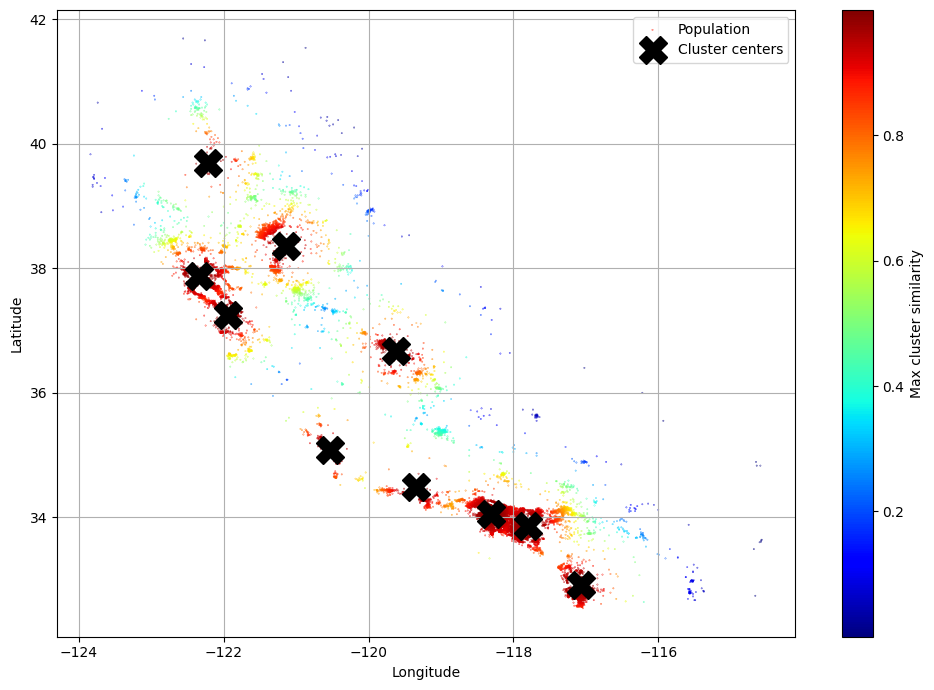

In [175]:
# Gaussian RBF similarity to the nearest cluster center
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(kmeans.cluster_centers_[:, 1],
         kmeans.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot_kmeans")
plt.show()

Let's Create Custom Class KMeans Similarity:

In [176]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

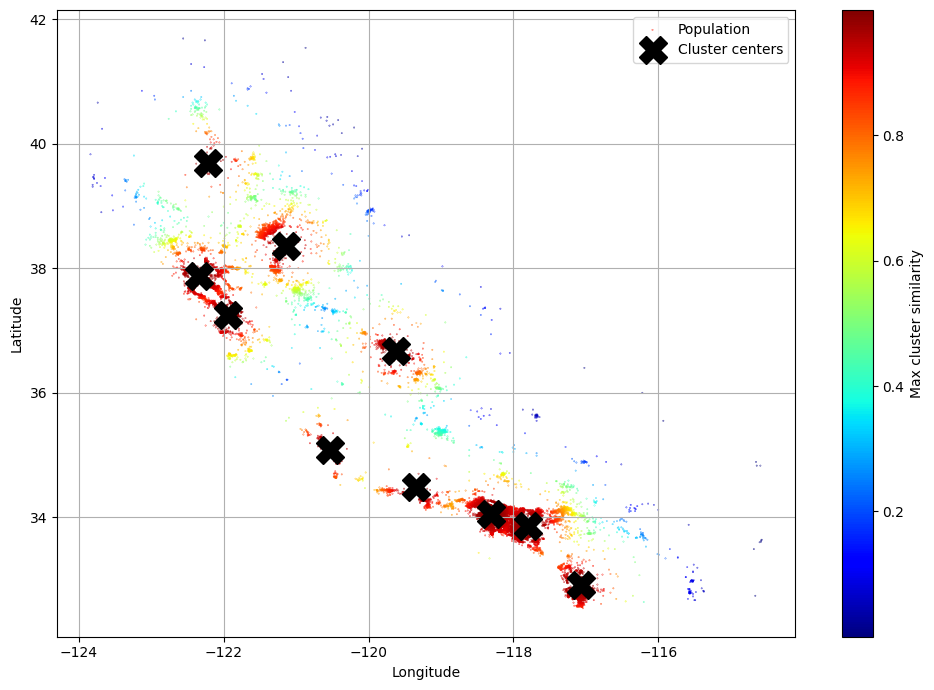

In [177]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

# Gaussian RBF similarity to the nearest cluster center
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot_custom_class")
plt.show()

This should do the trick

## 4.5. Creating pipeline for data preprocessing

We did a lot of preparation and exploring, Now I will create a pipeline that does all of this. Let's recap:
* Missing Values:
    1. In numerical features will be imputed by replacing them with **median**
    2. In categorical features will be replaced by the **most frequent** category
* The categorical feature will be **one-hot encoded**
* Added some ratio features
    1. `bedroom_ratio`
    2. `rooms_per_house`
    3. `people_per_house`
* A few cluster similarity features will be added.
* Features with have long tails will replaced,
    1. ***Sqrt Root:*** `total_bedrooms`, `total_rooms`, `households`
    2. ***Log:*** `population`, `median_income`
* All numerical features will be standardized

The code that builds the pipeline to do all of this:

In [185]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio,
                            feature_names_out=ratio_name),
        StandardScaler()            
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

sqrt_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.sqrt, validate=True, inverse_func=np.square, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("room_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["population", "median_income"]),
    ("sqrt", sqrt_pipeline, ["total_bedrooms", "total_rooms", "households"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

Before using preprocessing I want to redo some data assignments:

In [186]:
# Training set assignments
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Impute some values for beginning
housing = impute_missing_values(housing)

housing_num, housing_cat = separate_numerical_categorical(housing)

In [187]:
# Drop Outliers
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(housing_num)

housing = housing.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

Let's fit preprocessing to DataFrame:

In [188]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(14396, 24)

In [189]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'room_per_house__ratio',
       'people_per_house__ratio', 'log__population', 'log__median_income',
       'sqrt__total_bedrooms', 'sqrt__total_rooms', 'sqrt__households',
       'geo__Cluster 0 similarity', 'geo__Cluster 1 similarity',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity', 'geo__Cluster 5 similarity',
       'geo__Cluster 6 similarity', 'geo__Cluster 7 similarity',
       'geo__Cluster 8 similarity', 'geo__Cluster 9 similarity',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)